In [2]:
import matplotlib.pyplot as plt
import numpy as np



In [3]:
class Sphere:
    """3D sphere class"""
    
    def __init__(self, center=(0.0,0.0,0.0), radius=1.0, color=(0.0,0.0,0.0)):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color, np.float32)

class SpheresScene:
    """
    a simple scene with only 3D spheres
    """
    
    def __init__(self):
        self.spheres = [] # a list of spheres
        
    def AddSphere(self, center=(0.0,0.0,0.0), radius=1.0, color=(0.0,0.0,0.0)):
        """add a sphere to the scene"""
        sphere = Sphere(center, radius, color)
        self.spheres.append(sphere)
        
    def IntersectRaySphere(self, sphere, O, D):
        """
        assume P is the point on the sphere
        < , > is the dot production
        -----------------------------------
        1) <P - C, P - C> = r^2 # sphere function
        2) P = O + tD           # assume P is on the ray
        
        plug 2) to 1):
        <O + tD - C, O + tD - C> = r^2
        
        because CO = O - C, rewrite the above equation as:
                          <CO + tD, CO + tD> = r^2
        =>   <CO, CO> + 2<CO, tD> + <tD, tD> = r^2
        =>   <CO, CO> + 2t<CO, D> + tt<D, D> = r^2
        
        now, we can solve for t
        """
        
        r = sphere.radius
        O = np.array(O) # origin of the ray
        D = np.array(D) # direction of the ray
        C = sphere.center # center of the sphere
        CO = O - C
        
        a = np.dot(D, D)
        b = 2*np.dot(CO, D)
        c = np.dot(CO, CO) - r**2
        
        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            return float('inf'), float('inf') # no solution
        
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)

        return t1, t2
        
    def TraceRay(self, O, D, t_max):
        """
        O: the origin of the ray
        D: the direction (a unit vector) of the ray
        t_min and t_max define the ray tracing range
        --------------
        P = O + t * D
        """
        closest_t = float('inf')
        closest_sphere = None
        for sphere in self.spheres:
            t1, t2 = self.IntersectRaySphere(sphere, O, D)
            if t1 < t_max and t1 < closest_t and t1 > 0:
                closest_t = t1
                closest_sphere = sphere
            if t2 < t_max and t2 < closest_t and t2 > 0:
                closest_t = t2
                closest_sphere = sphere
        if closest_sphere is None:
            return np.array((0.0,0.0,0.0)) # black color
        return np.array(closest_sphere.color)
    
    
            

In [4]:
class Camera:
    """camera class"""
    
    def __init__(self, center = (0.0,0.0,0.0), 
                 width = 256, height = 256,
                 p_width = 256, p_height = 256, d=1, t_max=100):
        self.center = center     # camera center
        self.width = width       # width of the canvas
        self.height = height     # height of the canvas
        self.p_width = p_width   # project plane width
        self.p_height = p_height # project plane height
        self.d = d  # d is the distance between the camera to the projection plane
        self.t_min = 0
        self.t_max = t_max # ray tracing maximum range
        self.center_x = self.width // 2
        self.center_y = self.height // 2
        self.buffer = np.zeros((self.height, self.width, 3), dtype=np.uint8) # 8-bit depth
        
    def Clear(self):
        """clear the display buffer"""
        self.buffer = np.zeros((self.height, self.width, 3), dtype=np.uint8)
    
    def PutPixel(self, x, y, color):
        """
        set the pixel color of (x,y)
        Note that: the center of canvas is the origin of coordinate system
        """
        # convert to the array coordinate system
        x_ = self.center_x + x
        y_ = self.center_y - y
        
        # convert floating-point color to integer if needed
        if type(color[0]) is float or type(color[0]) is np.float32:
            color = np.array(color).clip(0, 1.0)
            color = np.array(color * 255, dtype=np.uint8)
        else:
            color = np.array(color, dtype=np.uint8).clip(0, 255)
        
        # set the pixel color
        if x_ >= 0 and x_ < self.width and y_ >= 0 and y_ < self.height:
            self.buffer[y_, x_] = color

    def ArrayToCanvas(self, x_, y_):
        """convert column and row indices (x_, y_) to (x,y) on canvas"""
        x = x_ - self.center_x
        y = self.center_y - y_
        return x, y
            
    def CanvasToViewport(self, x, y):
        """
        determine which square on the viewport (the projection plane)
        corresponds to this pixel.
        in other words,
        for each pixel (x,y) on the canvas, we can determine its
        corresponding point on the viewport (Vx, Vy, d)
        """
        return np.array((x*self.p_width/self.width, 
                        y*self.p_height/self.height, 
                        self.d))
    
    def RayTracing(self, scene):
        O = np.array(self.center)
        
        self.Clear()
        
        # scan all pixels on canvas
        for x_ in range(0, self.width):
            for y_ in range(0, self.height):
                x, y = self.ArrayToCanvas(x_, y_)
                D = self.CanvasToViewport(x, y)
                color = scene.TraceRay(O, D, self.t_max)
                self.PutPixel(x, y, color)
    
        return self.buffer
    

## Render 3D Spheres with Ray Tracing

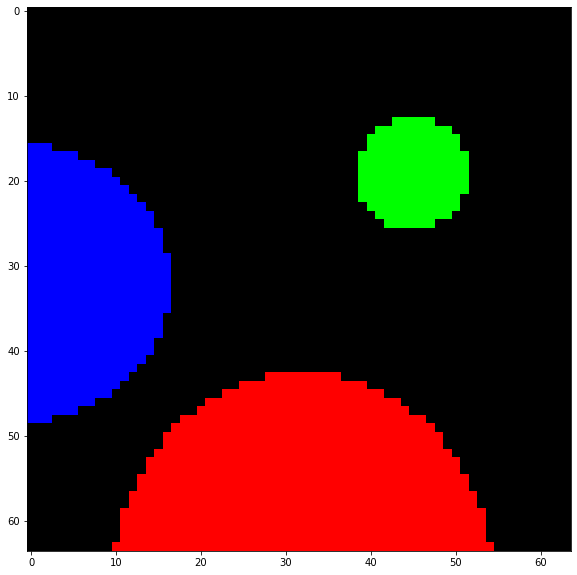

In [5]:
# create a camera
camera = Camera(center=(0.0,0.0,0.0), width=64, height=64, 
                p_width=1, p_height=1, d=1, t_max=1000)


# add some spheres to the scene
sphere_scene = SpheresScene()
sphere_scene.AddSphere(center=(0.0,-1.5,3.0), radius=1.0, color=(1.0,0.0,0.0) )
sphere_scene.AddSphere(center=(2.0,2.0,10.0), radius=1.0, color=(0.0,1.0,0.0) )
sphere_scene.AddSphere(center=(-2.0,0.0,4.0), radius=1.0, color=(0.0,0.0,1.0) )


img = camera.RayTracing(sphere_scene)

plt.figure(figsize=(10,10))
plt.imshow(img)

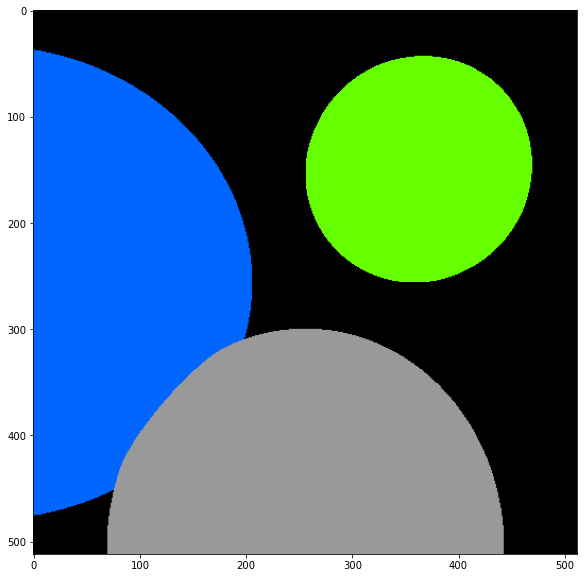

In [6]:
# create a camera
camera = Camera(center=(0.0,0.0,0.0), width=512, height=512, 
                p_width=1, p_height=1, d=1, t_max=100)


# add some spheres to the scene
sphere_scene = SpheresScene()
sphere_scene.AddSphere(center=(0.0,-1.5,3.5), radius=1.2, color=(0.6,0.6,0.6) )
sphere_scene.AddSphere(center=(2.0,2.0,10.0), radius=2.0, color=(0.4,1.0,0.0) )
sphere_scene.AddSphere(center=(-2.0,0.0,4.0), radius=1.6, color=(0.0,0.4,1.0) )


img = camera.RayTracing(sphere_scene)

plt.figure(figsize=(10,10))
plt.imshow(img)